In [1]:
from pyspark.sql import SparkSession
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'secrets/serviceKey.json'


# JAR paths for BigQuery and GCS connectors
bigquery_connector_jar = "spark-bigquery-connector.jar"
gcs_connector_jar = "gcs-connector.jar"


# Create SparkSession with both connectors
spark = SparkSession.builder \
    .appName("PySpark with BigQuery and GCS") \
    .config("spark.jars", f"{bigquery_connector_jar},{gcs_connector_jar}") \
    .config("spark.sql.catalog.spark_bigquery", "com.google.cloud.spark.bigquery.BigQueryCatalog") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "secrets/serviceKey.json") \
    .config("spark.bigquery.projectId", "idmpproject-441123") \
    .getOrCreate()

spark

24/11/20 16:07:50 WARN Utils: Your hostname, sabaris-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.110.50.201 instead (on interface en0)
24/11/20 16:07:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/11/20 16:07:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Specify the BigQuery table
project_id = "idmpproject-441123"
dataset_id = "uberFareEstimation"
table_name = "uber_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
uber_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
uber_df.show()

+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|distance|cab_type|      time_stamp|       destination|       source|price|surge_multiplier|    id|    name|
+--------+--------+----------------+------------------+-------------+-----+----------------+------+--------+
|    0.94|    Uber|2018-11-28T23:00|         North End|North Station|  4.5|             1.0| 39765|UberPool|
|    0.94|    Uber|2018-12-14T19:00|         North End|North Station|  4.5|             1.0|437984|UberPool|
|    0.63|    Uber|2018-11-27T21:00|Financial District|South Station|  4.5|             1.0|  1644|UberPool|
|    0.63|    Uber|2018-12-15T15:00|Financial District|South Station|  4.5|             1.0| 10780|UberPool|
|    0.63|    Uber|2018-12-15T13:00|Financial District|South Station|  4.5|             1.0| 21598|UberPool|
|    0.63|    Uber|2018-11-28T20:00|Financial District|South Station|  4.5|             1.0| 25567|UberPool|
|    0.63|    Uber|

In [ ]:
table_name = "lyft_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
lyft_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
lyft_df.show()

+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|distance|cab_type|      time_stamp|       destination|              source|price|surge_multiplier|    id|  name|
+--------+--------+----------------+------------------+--------------------+-----+----------------+------+------+
|     1.0|    Lyft|2018-12-02T10:00|Financial District|    Haymarket Square|  2.5|             1.0|266234|Shared|
|     1.0|    Lyft|2018-12-02T07:00|         North End|  Financial District|  2.5|             1.0|358706|Shared|
|     1.0|    Lyft|2018-12-17T02:00|Financial District|    Haymarket Square|  2.5|             1.0|401970|Shared|
|     1.0|    Lyft|2018-11-27T00:00|Financial District|    Haymarket Square|  2.5|             1.0|536179|Shared|
|     1.0|    Lyft|2018-12-16T19:00|     North Station|           North End|  2.5|             1.0|572308|Shared|
|    1.25|    Lyft|2018-12-14T09:00|          Back Bay|Northeastern Univ...|  2.5|      

In [4]:
table_name = "weather_data"

bigquery_table = f"{project_id}.{dataset_id}.{table_name}"

# Read data from BigQuery into a Spark DataFrame
weather_df = spark.read \
    .format("bigquery") \
    .option("table", bigquery_table) \
    .load()

# Show the first few rows of the DataFrame
weather_df.show()

+-----+--------------------+------+--------+----+----------------+--------+----+
| temp|            location|clouds|pressure|rain|      time_stamp|humidity|wind|
+-----+--------------------+------+--------+----+----------------+--------+----+
|36.24|              Fenway|   0.0| 1012.38| 0.0|2018-12-16T12:00|    0.69|6.72|
|36.25|Northeastern Univ...|   0.0| 1012.38| 0.0|2018-12-13T23:00|    0.69|6.77|
|36.26|    Theatre District|   0.0| 1012.38| 0.0|2018-12-16T02:00|    0.69|6.86|
|36.26|            West End|   0.0| 1012.37| 0.0|2018-11-29T18:00|    0.69|6.84|
|29.97|            Back Bay|   0.0|  1015.2| 0.0|2018-11-29T03:00|    0.85|2.41|
|29.95|         Beacon Hill|   0.0| 1015.19| 0.0|2018-12-14T18:00|    0.85|2.43|
|29.85|   Boston University|   0.0|  1015.2| 0.0|2018-11-27T11:00|    0.85|2.33|
|29.83|              Fenway|   0.0|  1015.2| 0.0|2018-12-16T04:00|    0.85|2.35|
|29.98|  Financial District|   0.0| 1015.19| 0.0|2018-12-02T19:00|    0.85|2.48|
|29.99|    Haymarket Square|

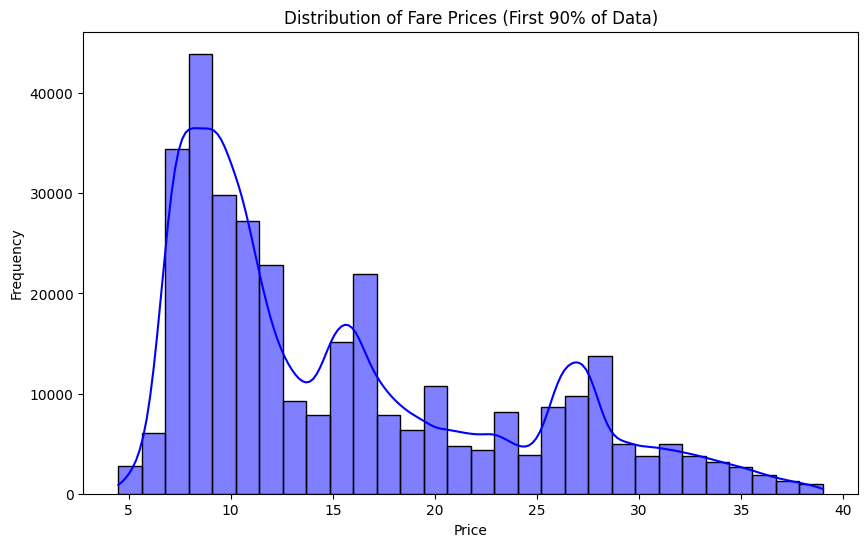

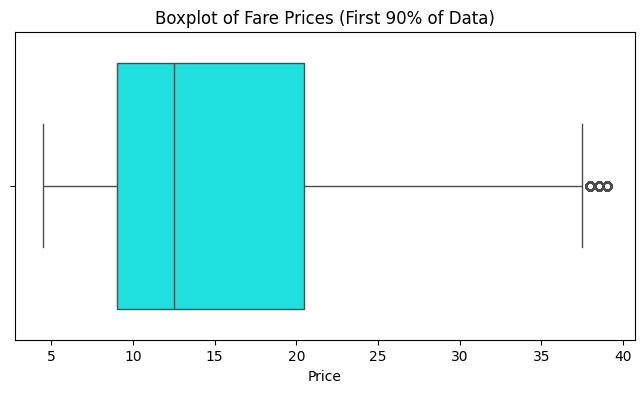

In [8]:
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the 90th percentile value for price
percentile_90 = uber_df.approxQuantile("price", [0.99], 0.001)[0]

# Filter the DataFrame to include only the first 90% of prices
filtered_data = uber_df.filter(col("price") <= lit(percentile_90))

# Convert the filtered data to Pandas
filtered_price_data = filtered_data.select("price").toPandas()

# Plot Histogram for the first 90% of prices
plt.figure(figsize=(10, 6))
sns.histplot(filtered_price_data['price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Fare Prices (First 90% of Data)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Plot Boxplot for the first 90% of prices
plt.figure(figsize=(8, 4))
sns.boxplot(x=filtered_price_data['price'], color='cyan')
plt.title('Boxplot of Fare Prices (First 90% of Data)')
plt.xlabel('Price')
plt.show()